In [1]:
import wfdb
import wfdb.processing
from wfdb.processing import xqrs_detect
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.integrate import trapz
from sklearn.decomposition import PCA
from scipy.signal import resample
from sklearn.impute import SimpleImputer

%matplotlib inline

# Using the wfdb library to read the data, for one record.

(array(['A', 'N'], dtype='<U1'), array([453,  39], dtype=int64))


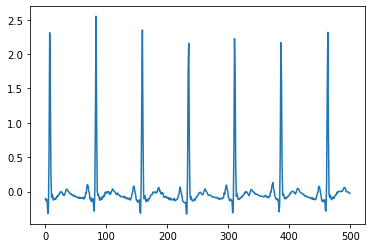

In [2]:
#main path for dataset
path = "apnea-ecg-database-1.0.0"

#read a sample record from dataset

Signal_record = wfdb.rdrecord(os.path.join(path, 'a04'), channels=[0])
outcome = wfdb.rdann(os.path.join(path,'a04'), extension='apn')
print(np.unique(outcome.symbol, return_counts=True))
#plot the start of the signal
plt.plot(Signal_record.p_signal[0:500])
plt.show()


## Data Labelling

In [3]:
def get_labels(signal,outcome):

    ecg_signal = signal.p_signal[:,0]
    
    # Get the annotation locations and types
    annotation_locs = outcome.sample
    annotation_types = outcome.symbol

    # Define the apnea event types
    apnea_types = ['H', 'A', 'O']

    # Label the ECG signals with the corresponding apnea events
    ecg_labels = []
    for i in range(len(ecg_signal)):
        if i in annotation_locs:
            idx = np.where(annotation_locs == i)[0][0]
            annotation_type = annotation_types[idx]
            if annotation_type in apnea_types:
                ecg_labels.append('A')
            else:
                ecg_labels.append('None')
        else:
            ecg_labels.append('None')

    return ecg_labels


ecg_labels = get_labels(signal=Signal_record,outcome=outcome)
labels_array = np.array(ecg_labels)
print(labels_array[:100])


['None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None'
 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None' 'None']


# Time domain features + functions
[Source for features mentioned](https://www.mdpi.com/2076-3417/12/9/4218)

feature | Description
---  | ---
RRmean |	Mean of RR intervals 
RMSSD | Root mean square of differences between adjacent RR intervals 
SDNN | Standard deviation of RR intervals 
NN50 | Number of adjacent RR intervals exceeding 50 milliseconds 
pNN50 |	Ratio of NN50 to the number of RR intervals 
HR	| Mean of heart rates 


## These are secondary functions that are called in time_domain_features() and frequency_domain_features

In [4]:
def calc_RR_intervals(ecg_signal, fs):
    '''
    ecg_signal: time series data
    fs: sample rate
    return: rr_intervals
    the RR interval is the time between two consecutive R peaks, returned in milliseconds
    '''
    qrs_inds = xqrs_detect(ecg_signal, fs=fs)
    # Calculate R-R intervals
    rr_intervals = np.diff(qrs_inds) / fs  # convert to seconds
    return rr_intervals
#calculates the R amplitudes RAMP signal
def calc_RAMP(ecg_sig):
    # linear spaced vector between 0.5 pi and 1.5 pi 
    v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)
    # use sine to approximate QRS feature
    peak_filter = np.sin(v)
    ecg_transformed = np.correlate(ecg_sig, peak_filter, mode="same")
    rr_peaks, _ = signal.find_peaks(ecg_transformed, distance=50)
    return rr_peaks



# Get time domain for one element (1-D)

In [5]:
# returns time domain features for a chunk of signal
def time_domain_features(ecg_signal, fs):
    '''
    ecg_signal: 1-D numpyarray time series ECG
    fs: sample rate
    return: RRmean, mean of RR intervals
            RRMSSD, Root mean square of differences between adjacent RR intervals
            SDNN, standard deviation of RR intervals
            NN50, Number of adjacent RR intervals differing by more than 50 ms
            pNN50, Proportion of NN50 divided by total number of RR intervals
            mean_HR Mean heart rate
    '''
    rr_intervals = calc_RR_intervals(ecg_signal, fs)
    RRmean = np.mean(rr_intervals)
    RRMSSD = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    SDNN = np.std(rr_intervals)
    NN50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pNN50 = NN50 / len(rr_intervals)
    mean_HR = 60 / RRmean
    return RRmean, RRMSSD, SDNN, NN50, pNN50, mean_HR

In [6]:
a, b, c,d,e,f = time_domain_features(Signal_record.p_signal[:,0], Signal_record.fs)
print(a, b, c, d, e, f)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
0.9531740952868526 0.10942736057210063 0.13357405779995368 0 0.0 62.947577254439885


# Frequency domain features

    Features | Description
	--- | ---
	VLF1, VLF2 | Very low frequency (0-0.04 Hz) component of the corresponding signal
	LF1, LF2 | Low frequency (0.04~0.15 Hz) component of the corresponding signal
	HF1, HF2 | High frequency (0.15~0.4 Hz) component of the corresponding signal
	LF/HF1, LF/HF2	| Ratio of LF to HF
	LFnorm1, LFnorm2 |	Normalized low frequency components
	HFnorm1, HFnorm2 |	Normalized high frequency components

Note: 1, 2 represent the frequency domain features of the RR interval and RAMP, respectively.

In [7]:
def frequency_domain(ecg_sig, fs):
    rri = calc_RR_intervals(ecg_sig, fs)
    rr_peaks = calc_RAMP(ecg_sig)
    # Estimate the spectral density using Welch's method
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    # calculate RR features
    fxx_RR, pxx_RR = signal.periodogram(x=rri, fs=fs)
    cond_vlf_RR = (fxx_RR >= 0) & (fxx_RR < 0.04)
    cond_lf_RR = (fxx_RR >= 0.04) & (fxx_RR < 0.15)
    cond_hf_RR = (fxx_RR >= 0.15) & (fxx_RR < 0.4)
    # calculate power in each band by integrating the spectral density 
    vlf_RR = trapz(pxx_RR[cond_vlf_RR], fxx_RR[cond_vlf_RR])
    lf_RR = trapz(pxx_RR[cond_lf_RR], fxx_RR[cond_lf_RR])
    hf_RR = trapz(pxx_RR[cond_hf_RR], fxx_RR[cond_hf_RR])
    # sum these up to get total power
    total_power_RR = vlf_RR + lf_RR + hf_RR
    # find which frequency has the most power in each band
    peak_vlf_RR = fxx_RR[cond_vlf_RR][np.argmax(pxx_RR[cond_vlf_RR])]
    peak_lf_RR = fxx_RR[cond_lf_RR][np.argmax(pxx_RR[cond_lf_RR])]
    peak_hf_RR = fxx_RR[cond_hf_RR][np.argmax(pxx_RR[cond_hf_RR])]
    lf_norm_RR = lf_RR/ total_power_RR
    hf_norm_RR = hf_RR / total_power_RR
    
    #calculate RAMP features
    fxx_RAMP, pxx_RAMP = signal.periodogram(x=rr_peaks, fs=fs)
    cond_vlf_RAMP = (fxx_RAMP >= 0) & (fxx_RAMP < 0.04)
    cond_lf_RAMP = (fxx_RAMP >= 0.04) & (fxx_RAMP < 0.15)
    cond_hf_RAMP = (fxx_RAMP>= 0.15) & (fxx_RAMP < 0.4)
    # calculate power in each band by integrating the spectral density 
    vlf_RAMP = trapz(pxx_RAMP[cond_vlf_RAMP], fxx_RAMP[cond_vlf_RAMP])
    lf_RAMP = trapz(pxx_RAMP[cond_lf_RAMP], fxx_RAMP[cond_lf_RAMP])
    hf_RAMP = trapz(pxx_RAMP[cond_hf_RAMP], fxx_RAMP[cond_hf_RAMP])
    # sum these up to get total power
    total_power_RAMP = vlf_RAMP + lf_RAMP + hf_RAMP
    # find which frequency has the most power in each band
    peak_vlf_RAMP = fxx_RAMP[cond_vlf_RAMP][np.argmax(pxx_RAMP[cond_vlf_RAMP])]
    peak_lf_RAMP = fxx_RAMP[cond_lf_RAMP][np.argmax(pxx_RAMP[cond_lf_RAMP])]
    peak_hf_RAMP = fxx_RAMP[cond_hf_RAMP][np.argmax(pxx_RAMP[cond_hf_RAMP])]
    lf_norm_RAMP = lf_RAMP / total_power_RAMP
    hf_norm_RAMP = hf_RAMP / total_power_RAMP  


    #map values to aforementioned values
    VLF1 = vlf_RR; VLF2 = vlf_RAMP # VLF1, VLF2 | Very low frequency (0-0.04 Hz) component of the corresponding signal
    LF1 = lf_RR; LF2 = lf_RAMP # LF1, LF2 | Low frequency (0.04~0.15 Hz) component of the corresponding signal
    HF1 = hf_RR; HF2 = hf_RAMP # HF1, HF2 | High frequency (0.15~0.4 Hz) component of the corresponding signal

    LF_HF1 = lf_RR/hf_RR; LF_HF2 = lf_RAMP/hf_RAMP # LF/HF1, LF/HF2	| Ratio of LF to HF
    LF_NORM1 = lf_norm_RR; LF_NORM2 = lf_norm_RAMP# LFnorm1, LFnorm2 |	Normalized low frequency components
    HF_NORM1 = hf_norm_RR; HF_NORM2 = hf_norm_RAMP # HFnorm1, HFnorm2 |	Normalized high frequency components
    return  [VLF1, VLF2, LF1, LF2, HF1, HF2, LF_HF1, LF_HF2, LF_NORM1, LF_NORM2, HF_NORM1, HF_NORM2]

results = frequency_domain(Signal_record.p_signal[:,0], Signal_record.fs)
print(results)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[0.005496283843495939, 706945036269.3286, 0.00039639219065404363, 20444735810.202282, 0.0003350036802827222, 4630210108.847871, 1.1832472715509077, 4.415509302943818, 0.06365006050895666, 0.027929204540404217, 0.0537926957782283, 0.0063252509788132094]


# Grouping by record name
## Making an array of arrays that represents the ecg signals for a single record name.

In [8]:
# Get a list of all record names in the database
record_names = wfdb.get_record_list('apnea-ecg')

# Initialize an empty list to store the ECG data arrays where ecg_data is an array of arrays
ecg_data = []
ecg_labels=[]
# Loop over all record names and read the ECG signal data for each record
for record_name in record_names:
    # Read the ECG signal data for the current record
    signal_record = wfdb.rdrecord(os.path.join(path, record_name), channels=[0])
    ecg_signal = signal_record.p_signal[:,0]
    # Append the ECG signal data to the list of data arrays
    ecg_data.append(ecg_signal)
    ecg_labels=get_labels(Signal_record,outcome)



# Convert the list of data arrays to a NumPy array
ecg_data_array = np.array(ecg_data)
ecg_labels_array= np.array(ecg_labels)

# Print the shape of the resulting array
print(ecg_labels[:100])


['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']


C:\Users\ahmed elsarta\AppData\Local\Temp\ipykernel_1696\249605420.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ecg_data_array = np.array(ecg_data)


# Adding labels to the data signals

In [9]:
# Set the path to the Apnea-ECG database
path = "apnea-ecg-database-1.0.0"

# Define a list of record names to read, because using a variable resulted in mismatch, so we will hard coding some of the files 
record_names = ['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 
                'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 
                'b01', 'b02', 'b03', 'b04', 'b05', 
                ]
# Initialize empty lists to store the ECG data and labels
ecg_data = []
labels = []

# Loop over all record names and read the ECG signal and annotation data for each record
for record_name in record_names:
    signal_record = wfdb.rdrecord(os.path.join(path, record_name), channels=[0])
    ecg_signal = signal_record.p_signal[:,0]
    outcome = wfdb.rdann(os.path.join(path, record_name), 'apn')
    label = np.any(np.isin(outcome.symbol, ['H', 'A', 'O']))
    ecg_data.append(ecg_signal)
    labels.append(label)

# Convert the lists to NumPy arrays
ecg_data_array = np.array(ecg_data)
labels_array = np.array(labels)
print(ecg_data_array)
print(labels_array)

[array([-0.06 , -0.065, -0.06 , ...,  0.   ,  0.   ,  0.   ])
 array([-0.02 , -0.02 , -0.025, ...,  0.   ,  0.   ,  0.   ])
 array([-0.23 , -0.105,  0.   , ...,  0.   ,  0.   ,  0.   ])
 array([-0.105, -0.13 , -0.11 , ...,  0.   ,  0.   ,  0.   ])
 array([-0.135, -0.185, -0.175, ...,  0.01 ,  0.04 ,  0.05 ])
 array([-0.06 , -0.055, -0.07 , ...,  0.   ,  0.   ,  0.   ])
 array([-0.17 , -0.16 , -0.17 , ..., -0.15 , -0.155, -0.125])
 array([-0.24 , -0.35 , -0.73 , ...,  0.04 ,  0.03 , -0.005])
 array([ 0.03,  0.01, -0.02, ...,  0.  ,  0.  ,  0.  ])
 array([-0.235, -0.255, -0.31 , ..., -0.935, -1.375, -0.665])
 array([-0.045, -0.02 , -0.02 , ...,  0.   ,  0.   ,  0.   ])
 array([-0.05 , -0.115,  0.125, ...,  0.   ,  0.   ,  0.   ])
 array([-0.165, -0.06 , -0.155, ..., -0.165, -0.135, -0.225])
 array([-0.12 , -0.125, -0.125, ...,  0.   ,  0.   ,  0.   ])
 array([-0.135, -0.11 , -0.08 , ..., -0.4  , -0.38 , -0.38 ])
 array([-0.465, -0.08 ,  1.425, ..., -0.15 , -0.155, -0.15 ])
 array([-0.05 

C:\Users\ahmed elsarta\AppData\Local\Temp\ipykernel_1696\1146217542.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ecg_data_array = np.array(ecg_data)


# Calculating parameters for the whole dataset


### The same concept is applied to all of the previous comments, so simply just uncomment the parts that you want to test. we could have used multiple for loops but, it would've been redundant to do so.


In [10]:
#calculating parameters for the whole dataset

record_names = wfdb.get_record_list('apnea-ecg')

# Loop over all record names and read the ECG signal data for each record
for record_name in record_names:
    # Read the ECG signal data for the current record
    signal_record = wfdb.rdrecord(os.path.join(path, record_name), channels=[0])
    ecg_signal = signal_record.p_signal[:,0]
    a, b, c,d,e,f = time_domain_features(Signal_record.p_signal[:,0], Signal_record.fs)
    print(a, b, c, d, e, f)
    results = frequency_domain(Signal_record.p_signal[:,0], Signal_record.fs)
    print(results)
    rr_interval= calc_RR_intervals(ecg_signal, Signal_record.fs)
    print(rr_interval)
    rr= calc_RAMP(ecg_signal)
    print(rr)


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
0.9531740952868526 0.10942736057210063 0.13357405779995368 0 0.0 62.947577254439885
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[0.005496283843495939, 706945036269.3286, 0.00039639219065404363, 20444735810.202282, 0.0003350036802827222, 4630210108.847871, 1.1832472715509077, 4.415509302943818, 0.06365006050895666, 0.027929204540404217, 0.0537926957782283, 0.0063252509788132094]
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[0.89 0.84 0.88 ... 0.86 0.75 0.82]
[     43     132     216 ... 2956292 2956372 2956454]
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameter

KeyboardInterrupt: 

# Feature reduction 

531


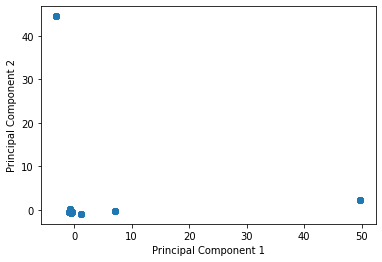

In [ ]:

# Set the desired length for resampling the ECG signals
desired_length = 1000

# Loop over all record names and read the ECG signal and annotation data for each record, using the same technique as before but with some modifications
for record_name in record_names:
    signal_record = wfdb.rdrecord(os.path.join(path, record_name), channels=[0])
    ecg_signal = signal_record.p_signal[:,0]

    # Resample the ECG signal to the desired length
    ecg_resampled = resample(ecg_signal, desired_length)

    # Check for missing values in the resampled signal
    if np.isnan(ecg_resampled).any():
        # Fill in missing values using mean imputation
        imputer = SimpleImputer()
        ecg_imputed = imputer.fit_transform(ecg_resampled.reshape(-1, 1))
        ecg_imputed = ecg_imputed.flatten()
    else:
        ecg_imputed = ecg_resampled

    ecg_data.append(ecg_imputed)

# Find the length of the longest signal
max_length = max([len(signal) for signal in ecg_data])

# Zero-pad all signals to match the length of the longest signal
ecg_data_padded = np.zeros((len(ecg_data), max_length))
for i, signal in enumerate(ecg_data):
    ecg_data_padded[i, :len(signal)] = signal

# Apply PCA to the ECG data
pca = PCA(n_components=2)
pca.fit(ecg_data_padded)
print(len(ecg_data_padded))
ecg_data_pca = pca.transform(ecg_data_padded)
# Plot the PCA results
import matplotlib.pyplot as plt
plt.scatter(ecg_data_pca[:,0], ecg_data_pca[:,1], )
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()